In [1]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt

## Load in data

#### Get data from user selection

In [2]:
#For now just use the exported csv
user_df = pd.read_csv('newway_data.csv')

In [3]:
user_df = user_df.drop(columns = ['uri', 'duration_ms'])

In [4]:
user_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.624,0.886,4,-6.046,1,0.0351,0.1000,0.941000,0.0943,0.772,155.249
1,0.623,0.766,4,-7.445,1,0.0531,0.1030,0.019300,0.1580,0.550,153.150
2,0.475,0.624,11,-8.698,0,0.0291,0.0258,0.000229,0.1810,0.779,173.078
3,0.646,0.611,0,-6.516,1,0.0272,0.1710,0.000000,0.0634,0.272,109.051
4,0.543,0.526,2,-9.703,1,0.0582,0.0447,0.053300,0.0778,0.384,153.000


In [5]:
user_sub = user_df[['energy', 'liveness', 'danceability', 'key', 'mode', 'speechiness', 
                    'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]

In [6]:
vibe_np = user_sub.agg('mean').to_numpy()
vibe = user_sub.agg('mean').to_frame()

In [7]:
vibe

,0
energy,0.677938
liveness,0.213422
danceability,0.581875
key,5.187500
mode,0.562500
speechiness,0.052166
loudness,-7.249156
acousticness,0.172883
instrumentalness,0.136619
valence,0.591938


#### Get Reddit data from MongoDB

In [8]:
with open('db_pass.txt', 'r') as f:
    db_pass = f.read()

In [9]:
client = pymongo.MongoClient()

In [10]:
#Specify database and collection
db = client['RedditCollect']
collection = db['indieheads']

In [11]:
db.list_collection_names()

['indieheads', 'Alternativerock']

In [12]:
cursor = collection.find({})
reddit_df = pd.DataFrame(list(cursor))

In [15]:
#Select track features of interest
#First try the feature in each category with the highest variation
reddit_features = reddit_df[['energy', 'danceability', 'key', 'speechiness', 
                             'acousticness', 'instrumentalness', 'valence', 'tempo']]

#Drop features the may not be important
# 'danceability', 'energy', 'key', 'mode', 'speechiness', 'loudness'
# 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'


In [ ]:
plt.scatter(reddit_features.energy, reddit_features.loudness, c=reddit_features.liveness, alpha = 0.6, s=10)

## Preprocessing

In [16]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scale_cols = list(reddit_features.columns)

#create and fit scaler
scaler = StandardScaler()
scaler.fit(reddit_features[scale_cols])

#scale selected data
reddit_features[scale_cols] = scaler.transform(reddit_features[scale_cols])


In [18]:
reddit_features.head()

,energy,loudness,liveness
0,0.230686,-0.211590,-0.136565
1,-0.509523,0.851861,-0.681291
2,-2.083638,-1.954533,-0.563376
3,-1.427757,-1.574393,-0.541674
4,0.272850,0.886232,-0.577844


## Model Building

#### K-Means

In [19]:
from sklearn.cluster import KMeans

In [20]:
X = reddit_features.copy()

In [ ]:
X.to_numpy()

In [289]:
k = 15
kmeans = KMeans(n_clusters = k, init = 'random', random_state = 1)
y_pred = kmeans.fit(X)

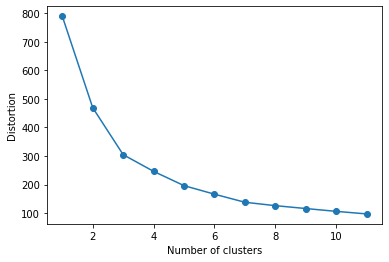

In [22]:
#Use elbow method to determine optimal clusters
distort = []
max_cluster = 12
for i in range(1, max_cluster):
    km = KMeans(n_clusters=i, init='random', random_state=42)
    km.fit_predict(X)
    distort.append(km.inertia_)

# plot
plt.plot(range(1, max_cluster), distort, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [290]:
reddit_df['cluster'] = list(y_pred.labels_)

In [291]:
np.array([vibe])

array([[ 0.6779375 , -7.24915625,  0.21342188]])

In [292]:
user_cluster = kmeans.predict(np.array([vibe]))
user_cluster

array([0], dtype=int32)

In [293]:
reddit_df['cluster'].value_counts()

0     34
7     32
12    24
2     24
1     23
10    23
3     19
4     17
6     16
5     14
13    13
11     7
9      7
14     4
8      3
Name: cluster, dtype: int64

In [ ]:
suggested = reddit_df[reddit_df['cluster'] == 0]
top_suggested = suggested.sort_values(by = 'upvotes', ascending = False)
top_suggested.head(15)

In [300]:
#Create a funciton to classify every song in the user playlist to a cluster
def user_suggestion(user_df, fitted_metrics):
    user_sub = user_df[fitted_metrics]
    user_cluster = []
    
    for track in user_sub:
        user_cluster.append(kmeans.predict(np.array(track)))
        print(track)
    
    user_df['cluster'] = user_cluster
                            
    return user_df

### Cosine Similarity 

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [83]:
test_song = np.array([[0.624, 0.886, 4, 6.046, 1, 0.0351, 0.1000, 0.941000, 0.0943, 0.772, 155.249]])

In [84]:
test_song

array([[6.24000e-01, 8.86000e-01, 4.00000e+00, 6.04600e+00, 1.00000e+00,
        3.51000e-02, 1.00000e-01, 9.41000e-01, 9.43000e-02, 7.72000e-01,
        1.55249e+02]])

In [104]:
reddit_array = reddit_features.to_numpy()
cos_sim = []
for track in reddit_array:
    similarity = cosine_similarity(np.array([track]), vibe.T.to_numpy())
    cos_sim.append(similarity)

In [108]:
top_tracks_reddit = reddit_df.sort_values(by = 'cosine_sim', ascending = False)

In [110]:
top_10 = top_tracks_reddit.head(10)

In [111]:
top_10.head()

,_id,created,upvotes,url,subreddit,artist_all,track,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,cosine_sim
126,u49m9m,1.650034e+09,29,https://open.spotify.com/track/62lLZOUN0AmYBaw...,indieheads,Caamp,Apple Tree Blues,0.537,0.649,8,...,1,0.0308,0.51500,0.064100,0.119,0.737,173.027,spotify:track:62lLZOUN0AmYBaw6es63l5,212680,0.999989
7,ud1sr0,1.651061e+09,11,https://www.youtube.com/watch?v=sWrZOhYgZ7c,indieheads,Post Animal,Cancer Moon,0.554,0.665,5,...,1,0.0367,0.00236,0.000238,0.117,0.477,111.969,spotify:track:3f11SOnd3uSZjf8WbTk773,231268,0.999988
52,u8w23n,1.650571e+09,2,https://open.spotify.com/track/3Lz6teL5yOL4pp3...,indieheads,Sick Joy,talking to the drugs,0.603,0.793,6,...,1,0.0402,0.00912,0.088600,0.392,0.718,129.999,spotify:track:3Lz6teL5yOL4pp30hKj9LT,176799,0.999988
211,txvgl8,1.649277e+09,2,https://open.spotify.com/track/2S9ioeurLIMRV9X...,indieheads,Charlie Hickey,Dandelions,0.619,0.479,6,...,1,0.0369,0.71000,0.000125,0.171,0.627,128.071,spotify:track:2S9ioeurLIMRV9XIlsiBxS,218400,0.999978
37,uav6an,1.650808e+09,176,https://open.spotify.com/track/1gaByCFB1qArGJU...,indieheads,DJ Sabrina The Teenage DJ,Call You,0.575,0.796,6,...,1,0.1410,0.18400,0.000000,0.261,0.538,122.035,spotify:track:1gaByCFB1qArGJUIvgmolV,515410,0.999978


In [120]:
top_10 = top_10[['artist_all', 'track', 'upvotes']]
top_10.rename(columns = {'artist_all': 'Artist(s)', 'track': 'Track', 'upvotes': 'Upvotes'}, inplace = True)
top_10.reset_index(inplace = True, drop = True)

In [121]:
top_10

,Artist(s),Track,Upvotes
0,Caamp,Apple Tree Blues,29
1,Post Animal,Cancer Moon,11
2,Sick Joy,talking to the drugs,2
3,Charlie Hickey,Dandelions,2
4,DJ Sabrina The Teenage DJ,Call You,176
5,Pure Reason Revolution,Dead Butterfly,5
6,easy life,BEESWAX,16
7,Ezra Furman,Book of Our Names,24
8,Melody's Echo Chamber,Alma,101
9,Carrtoons,Homegrown,2


In [122]:
top_10.to_csv('test_top10.csv', index = False)

In [103]:
reddit_df['cosine_sim'].describe()

count    263.000000
mean       0.995788
std        0.004202
min        0.973435
25%        0.994994
50%        0.997293
75%        0.998266
max        0.999550
Name: cosine_sim, dtype: float64